- **ROUGE Score:** Measures content overlap with reference summaries.
- **BERTScore:** Assesses semantic similarity.
- **FactScore:** Evaluates factual alignment with the source document.
- **ROUGE Precision:** Ratio of correct n-grams in generated summary and the total n-grams in generated summary.
- **ROUGE F1 Score:** Ratio of correct n-grams in the generated summary and the correct n-grams in the reference summary.
- **ROUGE Recall:**  Harmonic mean between ROUGE Precision and ROUGE F1 – Score

In [ ]:
!pip install --upgrade datasets

In [ ]:
from datasets import load_dataset

# Load the CNN/DailyMail dataset
dataset = load_dataset("abisee/cnn_dailymail", "3.0.0")

# Inspect a sample
test_data = dataset['test'].select(range(2000)).shuffle(seed=12)  # First training sample
print(test_data["article"][0])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Gary Teale has hit back at Ronny Deila’s criticism of the St Mirren Park pitch. After the Parkhead club’s 2-0 win on Friday night, Deila branded most surfaces in the Scottish Premiership ‘terrible’ and argued that artificial pitches would make for better spectacles. But Teale insists the Norwegian’s criticism was unjustified and unfair on the Paisley club’s award-winning groundsman, Tommy Docherty. Celtic's Stefan Johansen slots  home his penalty to put his side 2-0 up against St Mirren . Gary Teale hit back at Celtic boss Ronny Deila for his criticism of the St Mirren Park pitch on Monday night . ‘I was surprised because I think our pitch is the best in the league,’ stated Teale. ‘It’s maybe a bit firm but it’s an excellent surface. Tommy, our groundsman, wins “Pitch of the Year” year after year and that’s a great acknowledgement for him and a great accolade for him. ‘So I was surprised at the comments because I’ve seen a lot of the pitches in the SPFL this year and a lot of them leav

In [ ]:
!pip install evaluate
!pip install sentence-transformers
!pip install bert_score
!pip install rouge_score

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from evaluate import load
import evaluate
import nltk
# Load nltk for texts
nltk.download("punkt", quiet=True)
nltk.download("punkt_tab", quiet=True) #
metric = evaluate.load("rouge")

# Fine-tuned model
finetuned_model = AutoModelForSeq2SeqLM.from_pretrained("/content/drive/MyDrive/checkpoint-37500")
finetuned_tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/checkpoint-37500")

# Original model
original_model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-small")
original_tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-small")


You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


In [ ]:
# Generate master files of generated summaries from original and fine-tuned model
import pandas as pd
import torch
import tqdm
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from datasets import load_dataset
from evaluate import load as load_metric

# Generate summaries
def generate_summaries(model, tokenizer, inputs, max_input_length=512, max_target_length=128):
    inputs_tokenized = tokenizer(inputs, return_tensors="pt", padding=True, truncation=True, max_length=max_input_length).to(model.device)
    with torch.no_grad():
        outputs = model.generate(input_ids=inputs_tokenized["input_ids"],
                                 attention_mask=inputs_tokenized["attention_mask"],
                                 max_length=max_target_length)
    return tokenizer.batch_decode(outputs, skip_special_tokens=True)

# Generate summaries from the finetuned and original model
original_preds = generate_summaries(original_model, original_tokenizer, test_data["article"])
finetuned_preds = generate_summaries(finetuned_model, finetuned_tokenizer, test_data["article"])
references = test_data["highlights"]
articles = test_data["article"]

# Build DataFrame
df = pd.DataFrame({
    "article": articles,
    "reference_summary": references,
    "original_summary": original_preds,
    "finetuned_summary": finetuned_preds,
})

# Show first few rows
print(df.head())

# save to CSV
df.to_csv("/content/drive/MyDrive/model_comparison_results-50k.csv", index=False)


                                             article  \
0  Gary Teale has hit back at Ronny Deila’s criti...   
1  Baghdad, Iraq (CNN)Izzat Ibrahim al-Douri, a f...   
2  Ben Stokes starred with the ball on the first ...   
3  (CNN)It's time for liberals to look local. Wit...   
4  Arsenal target Paolo Dybala has admitted that ...   

                                   reference_summary  \
0  Ronny Deila criticised the St Mirren Park pitc...   
1  U.S. military doesn't have further information...   
2  Ben Stokes took three wickets for 10 runs as E...   
3  Julian Zelizer: Washington is gridlocked and l...   
4  Arsenal and Juventus have reportedly bid for P...   

                                    original_summary  \
0  Gary Teale hit back at Ronny Deila for his cri...   
1                            Sunni-dominated regime.   
2  England dominated against a modest St Kitts & ...   
3  New Deal, the political landscape has been a s...   
4  Paolo Dybala has been linked with a number 

In [ ]:
import pandas as pd
from rouge_score import rouge_scorer
import bert_score
from tqdm import tqdm
import torch
from sentence_transformers import SentenceTransformer, util
from transformers import BartTokenizer, BartForConditionalGeneration
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize
import nltk

nltk.download('punkt')  # Make sure tokenizers are available

def compute_all_summary_metrics(csv_path: str) -> pd.DataFrame:
    import pandas as pd
    df = pd.read_csv(csv_path)

    required_columns = ['original_summary', 'finetuned_summary', 'reference_summary', 'article']
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")

    # Initialize models
    rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
    model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn").to("cuda" if torch.cuda.is_available() else "cpu")
    fact_model = SentenceTransformer('all-MiniLM-L6-v2')

    def score_fact_consistency_fallback(source, summary):
        emb_source = fact_model.encode(source, convert_to_tensor=True)
        emb_summary = fact_model.encode(summary, convert_to_tensor=True)
        return util.pytorch_cos_sim(emb_source, emb_summary).item()

    def compute_bleu(reference: str, hypothesis: str) -> float:
        reference_tokens = [word_tokenize(reference.lower())]
        hypothesis_tokens = word_tokenize(hypothesis.lower())
        smoothie = SmoothingFunction().method4
        return sentence_bleu(reference_tokens, hypothesis_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)

    results = []

    for _, row in tqdm(df.iterrows(), total=len(df)):
        ref = row['reference_summary']
        orig = row['original_summary']
        finetuned = row['finetuned_summary']
        source_doc = row['article']

        # ROUGE
        rouge_scores_orig = rouge.score(ref, orig)
        rouge_scores_fine = rouge.score(ref, finetuned)

        # BERTScore
        _, _, F1_orig = bert_score.score([orig], [ref], lang="en", verbose=False)
        _, _, F1_fine = bert_score.score([finetuned], [ref], lang="en", verbose=False)

        # FactScore (approximate)
        factscore_orig = score_fact_consistency_fallback(source_doc, orig)
        factscore_fine = score_fact_consistency_fallback(source_doc, finetuned)

        # BLEU
        bleu_orig = compute_bleu(ref, orig)
        bleu_fine = compute_bleu(ref, finetuned)

        results.append({
            "Article": source_doc,
            "Reference Summary": ref,
            "Original Summary": orig,
            "Fine-Tuned Summary": finetuned,

            # ROUGE-1
            "ROUGE1_Prec_Orig": rouge_scores_orig['rouge1'].precision,
            "ROUGE1_Rec_Orig": rouge_scores_orig['rouge1'].recall,
            "ROUGE1_F1_Orig": rouge_scores_orig['rouge1'].fmeasure,
            "ROUGE1_Prec_Fine": rouge_scores_fine['rouge1'].precision,
            "ROUGE1_Rec_Fine": rouge_scores_fine['rouge1'].recall,
            "ROUGE1_F1_Fine": rouge_scores_fine['rouge1'].fmeasure,

            # ROUGE-2
            "ROUGE2_Prec_Orig": rouge_scores_orig['rouge2'].precision,
            "ROUGE2_Rec_Orig": rouge_scores_orig['rouge2'].recall,
            "ROUGE2_F1_Orig": rouge_scores_orig['rouge2'].fmeasure,
            "ROUGE2_Prec_Fine": rouge_scores_fine['rouge2'].precision,
            "ROUGE2_Rec_Fine": rouge_scores_fine['rouge2'].recall,
            "ROUGE2_F1_Fine": rouge_scores_fine['rouge2'].fmeasure,

            # ROUGE-L
            "ROUGEL_Prec_Orig": rouge_scores_orig['rougeL'].precision,
            "ROUGEL_Rec_Orig": rouge_scores_orig['rougeL'].recall,
            "ROUGEL_F1_Orig": rouge_scores_orig['rougeL'].fmeasure,
            "ROUGEL_Prec_Fine": rouge_scores_fine['rougeL'].precision,
            "ROUGEL_Rec_Fine": rouge_scores_fine['rougeL'].recall,
            "ROUGEL_F1_Fine": rouge_scores_fine['rougeL'].fmeasure,

            # BERTScore
            "BERTScore_F1_Orig": F1_orig.item(),
            "BERTScore_F1_Fine": F1_fine.item(),

            # FactScore
            "FactScore_Orig": factscore_orig,
            "FactScore_Fine": factscore_fine,

            # BLEU Score
            "BLEU_Orig": bleu_orig,
            "BLEU_Fine": bleu_fine
        })

    return pd.DataFrame(results)


df = compute_all_summary_metrics("/content/drive/MyDrive/model_comparison_results-50k.csv")


Streaming output truncated to the last 5000 lines.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 38%|███▊      | 751/2000 [31:13<55:55,  2.69s/it]Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 38%|███▊      | 752/2000 [31:15<54:30,  2.62s/it]Some weights of Rober

In [ ]:
df.to_csv("/content/drive/MyDrive/model_generated_summary_scores-50k.csv", index=False)

In [ ]:
import pandas as pd
import polars as pl
df = pl.read_csv("/content/drive/MyDrive/model_generated_summary_scores-50k.csv")
display(df.mean())

Article,Reference Summary,Original Summary,Fine-Tuned Summary,ROUGE1_Prec_Orig,ROUGE1_Rec_Orig,ROUGE1_F1_Orig,ROUGE1_Prec_Fine,ROUGE1_Rec_Fine,ROUGE1_F1_Fine,ROUGE2_Prec_Orig,ROUGE2_Rec_Orig,ROUGE2_F1_Orig,ROUGE2_Prec_Fine,ROUGE2_Rec_Fine,ROUGE2_F1_Fine,ROUGEL_Prec_Orig,ROUGEL_Rec_Orig,ROUGEL_F1_Orig,ROUGEL_Prec_Fine,ROUGEL_Rec_Fine,ROUGEL_F1_Fine,BERTScore_F1_Orig,BERTScore_F1_Fine,FactScore_Orig,FactScore_Fine,BLEU_Orig,BLEU_Fine
str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
null,null,null,null,0.359989,0.242198,0.259868,0.28638,0.301483,0.283152,0.134074,0.095576,0.099872,0.09979,0.104801,0.098446,0.280423,0.180915,0.195416,0.209578,0.224109,0.208733,0.855855,0.859697,0.596514,0.643044,0.058122,0.062552


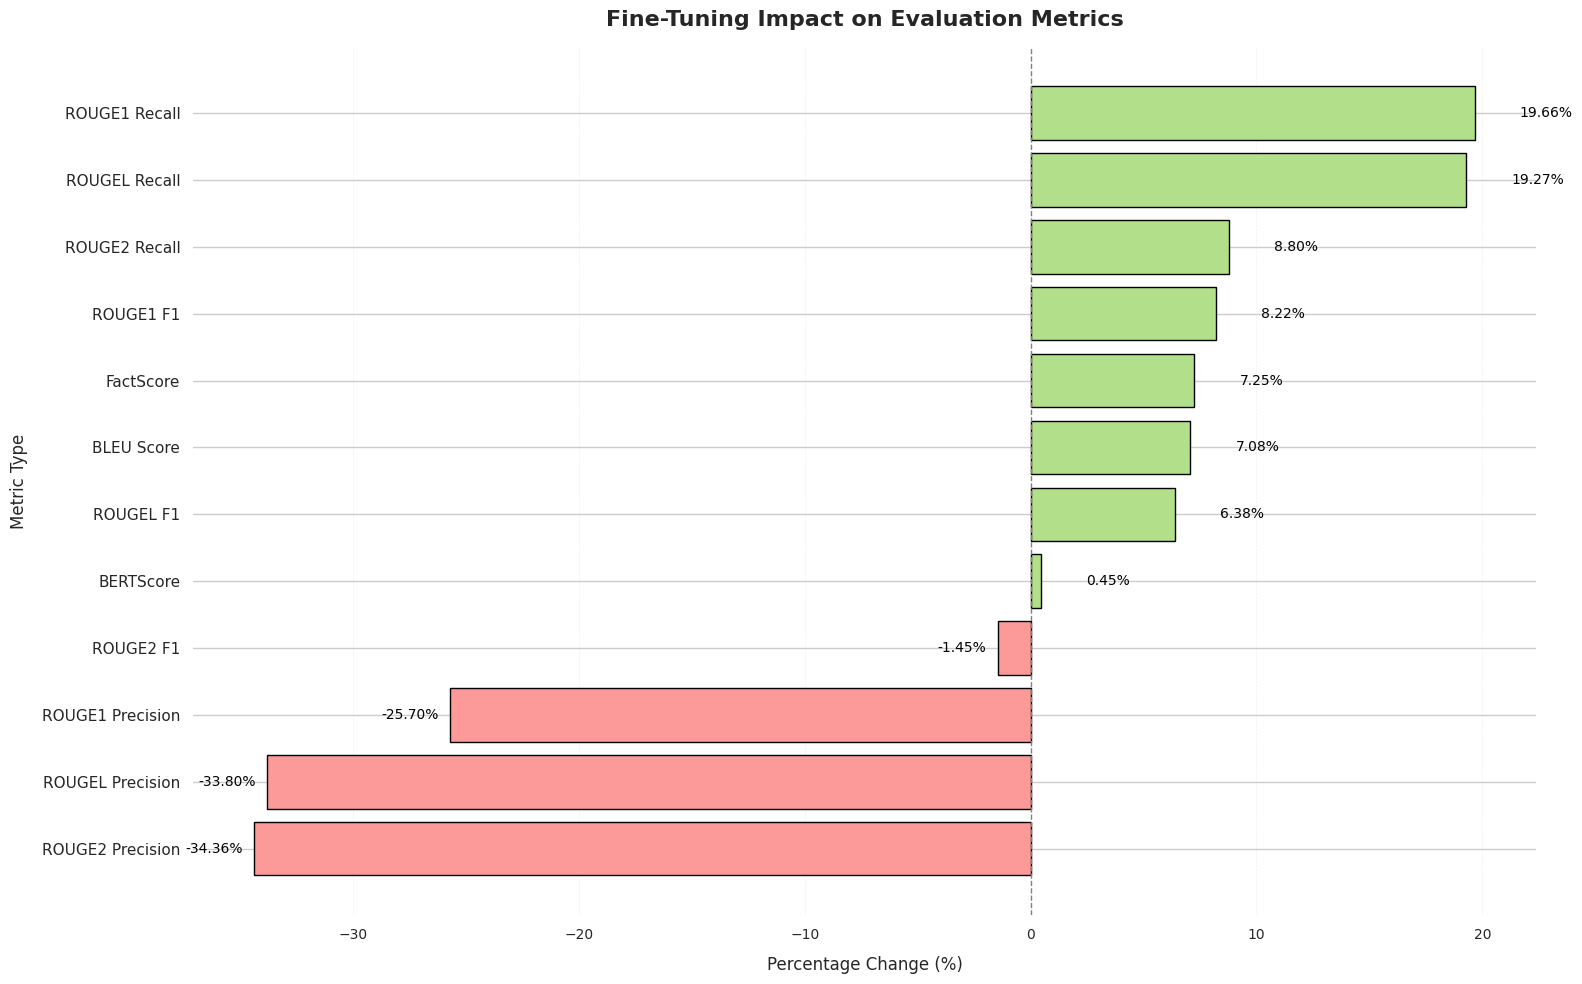

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set clean whitegrid theme
sns.set(style="whitegrid")

# Load your CSV
df = pd.read_csv("/content/Fine-tuned-Final-Metric.csv")
df = df.sort_values("% Change")

# Use lighter pastel shades
light_green = "#b2df8a"
light_red = "#fb9a99"
bar_colors = [light_green if val >= 0 else light_red for val in df["% Change"]]

# Set up the plot
plt.figure(figsize=(16, 10))
bars = plt.barh(df["Metric Type"], df["% Change"], color=bar_colors, edgecolor='black')

# Add labels next to each bar with better spacing
for bar, value in zip(bars, df["% Change"]):
    offset = 2 if value >= 0 else -0.5
    ha = 'left' if value >= 0 else 'right'
    plt.text(value + offset, bar.get_y() + bar.get_height()/2,
             f"{value:.2f}%", va='center', ha=ha, fontsize=10, color='black')

# Reference line at 0
plt.axvline(0, color='gray', linestyle='--', linewidth=1)

# Axis labels and title
plt.title("Fine-Tuning Impact on Evaluation Metrics", fontsize=16, weight='bold', pad=15)
plt.xlabel("Percentage Change (%)", fontsize=12, labelpad=10)
plt.ylabel("Metric Type", fontsize=12, labelpad=10)

# Improve ticks
plt.xticks(fontsize=10)
plt.yticks(fontsize=11)
plt.grid(axis='x', linestyle='--', linewidth=0.5, alpha=0.3)

# Clean up plot edges
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11 entries, ROUGE1 Precision to FactScore
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Original Model    11 non-null     float64
 1   Fine-tuned Model  11 non-null     float64
 2   % Change          11 non-null     float64
dtypes: float64(3)
memory usage: 652.0+ bytes
